## Inference of Hodgkin-Huxley model, with missing features

In [1]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.utils.io as io
import delfi.summarystats as ds
import lfimodels.hodgkinhuxley.utils as utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle

from lfimodels.hodgkinhuxley.HodgkinHuxley import HodgkinHuxley
from lfimodels.hodgkinhuxley.HodgkinHuxleyStatsSpikes_mf import HodgkinHuxleyStatsSpikes_mf
from delfi.utils.viz import plot_pdf
from sklearn import linear_model
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
true_params, labels_params = utils.obs_params()

seed = 1

I, t_on, t_off, dt = utils.syn_current()
obs = utils.syn_obs_data(I, dt, true_params, seed=seed)
obs_stats = utils.syn_obs_stats(I=I, t_on=t_on, t_off=t_off, dt=dt, params=true_params, seed=seed, summary_stats=3)

prior_log = False
m = HodgkinHuxley(I, dt, seed=seed, cython=True,prior_log=prior_log)
p = utils.prior(true_params=true_params, prior_extent=False,prior_log=prior_log, seed=seed)
s = HodgkinHuxleyStatsSpikes_mf(t_on=t_on, t_off=t_off)
g = dg.Default(model=m, prior=p, summary=s)

In [3]:
def param_transform(prior_log, x):
    if prior_log:
        return np.log(x)
    else:
        return x

def param_invtransform(prior_log, x):
    if prior_log:
        return np.exp(x)
    else:
        return x

## plotting original data and samples with missing spikes

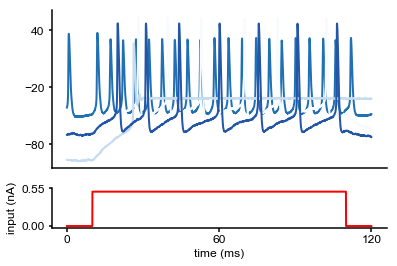

In [4]:
fig = plt.figure()

y_obs = obs['data']
t = obs['time']
duration = np.max(t)

A_soma = np.pi*((70.*1e-4)**2)  # cm2

COL = {}
COL['GT']   = (35/255,86/255,167/255)

num_samp = 3
num_colors = num_samp+1
cm1 = mpl.cm.Blues
col1 = [cm1(1.*i/num_colors) for i in range(num_colors)]

gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])

# sample from prior
x_samp = p.gen(n_samples=num_samp)
params = x_samp

V = np.zeros((len(t),num_samp))
stats_samp = []
for i in range(num_samp):
    m = HodgkinHuxley(I=I, dt=dt, seed=230+i, cython=True, prior_log=prior_log)
    x = m.gen_single(params[i,:])
    V[:,i] = x['data']
    plt.plot(t, V[:, i], color = col1[i-1], lw=2)
    stats_samp.append(s.calc([x]))

# plotting simulation
plt.plot(t, y_obs, color=COL['GT'], lw=2, label='observation')
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])

ax = plt.subplot(gs[1])
plt.plot(t,I*A_soma*1e3,color = 'r', lw=2)
plt.xlabel('time (ms)')
plt.ylabel('input (nA)')

ax.set_xticks([0, duration/2, duration])
ax.set_yticks([0, 1.1*np.max(I*A_soma*1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'));

In [5]:
stats_samp

[array([[  1.90000000e-01,   1.17500000e+01,   3.08979529e+01,
          -4.16116376e+01,  -4.74362253e+01,  -1.86689181e-03,
           7.90526316e-01]]),
 array([[  6.00000000e-02,   2.78800000e+01,   5.27195951e+01,
          -7.40438287e+01,  -5.31073112e+01,   6.20581124e-02,
           7.43333333e-01]]),
 array([[  1.00000000e-02,   2.61300000e+01,   2.59587167e+01,
          -9.70609820e+01,  -3.84354755e+01,              nan,
           7.50000000e-01]])]

## SNPE

In [6]:
seed = 1
impute_missing = True
g = dg.Default(model=m, prior=p, summary=s)
res = infer.SNPE(g, obs=obs_stats, pilot_samples=1000, n_hiddens=[50], seed=seed, prior_norm=True, n_components=2,
                 reg_lambda=0.01, impute_missing=impute_missing)

# run with N samples
out = res.run(5000, n_rounds=5, monitor=['imputation_values'])

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

0/|/Draw parameters (pilot run) :   0%|| 0/1000 [00:00<?, ?it/s]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

0/|/Run simulations (pilot run) :   0%|| 0/1000 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [4]:
# out[0][0]['imputation_values']

In [157]:
# np.any(np.isnan(out[1][0][1]))

In [7]:
# pickle.dump(out, open('miss_feat_run_2_round5.pkl','wb'))
# io.save(res, 'miss_feat_run_2_round5_res.pkl')

In [22]:
outld = pickle.load(open('miss_feat_run_2_round5.pkl', 'rb'))
res = io.load('miss_feat_run_2_round5_res.pkl')
posterior = res.predict(obs_stats)

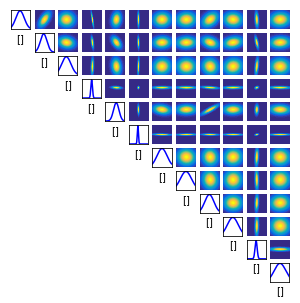

In [23]:
prior_min = res.generator.prior.lower
prior_max = res.generator.prior.upper

prior_lims = np.concatenate((prior_min.reshape(-1,1),
                             prior_max.reshape(-1,1)),
                            axis=1)

plot_pdf(posterior, lims=prior_lims, samples=None);

In [24]:
posterior.a

array([  9.99998868e-01,   1.13342253e-06], dtype=float32)

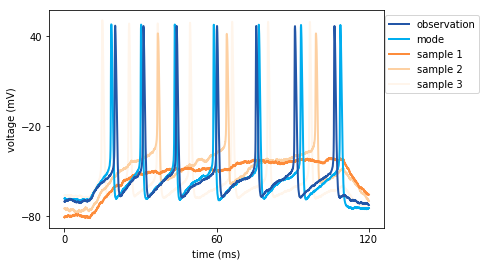

In [25]:
fig = plt.figure()

m, S = posterior.calc_mean_and_cov()
# m = posterior.xs[0].m
# S = posterior.xs[0].S
n_params = len(m)
y_obs = obs['data']
t = obs['time']
duration = np.max(t)

COL = {}
COL['GT']   = (35/255,86/255,167/255)
COL['SNPE'] = (0, 174/255,239/255)

num_samp = 3
num_colors = num_samp+1
cm1 = mpl.cm.Oranges
col1 = [cm1(1.*i/num_colors) for i in range(num_colors)]

# sampling at contour of 1 covariance away from mean (if samples from outside the prior box, contour is at prior box)
x_samp = np.random.randn(n_params,num_samp)
x_samp = np.divide(x_samp,np.linalg.norm(x_samp,axis=0))
x_samp = (np.dot(S,x_samp)).T+m

# # sample from posterior
# x_samp = posterior.gen(n_samples=num_samp)

# correct for samples outside the prior box
x_samp = np.maximum(x_samp,prior_min)
x_samp = np.minimum(x_samp,prior_max)

params = np.concatenate((np.array([m]),x_samp))

V = np.zeros((len(t),1+num_samp))
for i in range(1+num_samp):
    m = HodgkinHuxley(I=I, dt=dt, seed=230+i, cython=True, prior_log=prior_log)
    x = m.gen_single(params[i,:])
    V[:,i] = x['data']
#     V[:,i] = hh.sim_time(dt, t, I)[:,0]
    if i>0:
        plt.plot(t, V[:, i], color = col1[i-1], lw=2, label='sample '+str(num_samp-i+1))

# plotting simulation
plt.plot(t, V[:, 0], color=COL['SNPE'], lw=2, label='mode')
plt.plot(t, y_obs, color=COL['GT'], lw=2, label='observation')
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc='upper right')

ax.set_xticks([0, duration/2, duration])
ax.set_yticks([-80, -20, 40]);

## imputation values versus present features values

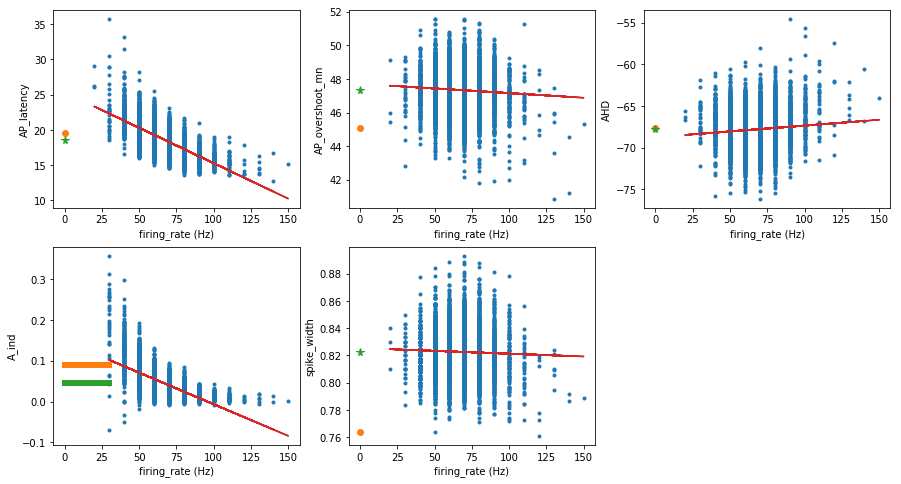

In [27]:
# results for inference where missing features have imputed values
out_mf = pickle.load(open('miss_feat_run_2_round5.pkl', 'rb'))
res_mf = io.load('miss_feat_run_2_round5_res.pkl')

label_obstats = np.array(['firing_rate','AP_latency', 'AP_overshoot_mn', 'rest_pot', 'AHD', 'A_ind', 'spike_width'])

imputation_values = out_mf[0][-1]['imputation_values'][-1]*res_mf.stats_std+res_mf.stats_mean
ind_obstats_mf = [1,2,4,5,6]

obs_stats_round = out_mf[1][-1][1]*res_mf.stats_std+res_mf.stats_mean

lr = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)


fig, ax = plt.subplots(figsize=(15,8))
for i in range(len(ind_obstats_mf)):
    xx = 1e3*obs_stats_round[:,0]
    yy = obs_stats_round[:,ind_obstats_mf[i]]
    xx = xx[np.isfinite(yy)].reshape(-1,1)
    yy = yy[np.isfinite(yy)]
    
    plt.subplot(2,3,i+1)
    plt.plot(xx,yy,'.')
    
    if i != 3:
        plt.plot(0,imputation_values[ind_obstats_mf[i]],'o',markersize=6)
        plt.plot(0,np.mean(yy),'*',markersize=8)
    else:
        plt.plot([0,30],imputation_values[ind_obstats_mf[i]] +[0,0],'-',linewidth=6)
        plt.plot([0,30],[0,0]+np.mean(yy),'-',linewidth=6)
    plt.xlabel(label_obstats[0]+' (Hz)')
    plt.ylabel(label_obstats[ind_obstats_mf[i]])
    
    # linear regression
    lr.fit(xx,yy)
    a = lr.coef_
    b = lr.intercept_
    plt.plot(xx,a*xx+b)

## samples from non-imputed (missing features are zero) inference vs imputed inference

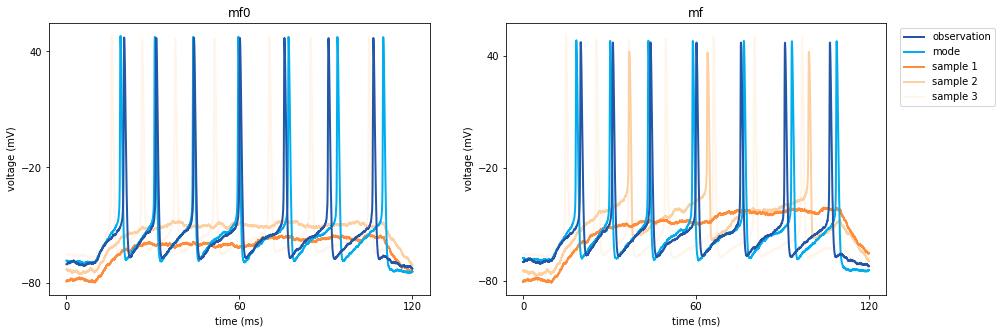

In [28]:
# results for inference where missing features are zero
out_mf0 = pickle.load(open('miss_feat0_run_2_round5.pkl', 'rb'))
res_mf0 = io.load('miss_feat0_run_2_round5_res.pkl')

# respective posteriors
posterior_mf0 = res_mf0.predict(obs_stats)
posterior_mf = res_mf.predict(obs_stats)

POST = [posterior_mf0,posterior_mf]
titles = ['mf0','mf']

# plotting
fig = plt.figure(figsize = (15,5))

for j in range(2):
    
    posterior = POST[j]
    m, S = posterior.calc_mean_and_cov()
    n_params = len(m)
    y_obs = obs['data']
    t = obs['time']
    duration = np.max(t)

    COL = {}
    COL['GT']   = (35/255,86/255,167/255)
    COL['SNPE'] = (0, 174/255,239/255)

    num_samp = 3
    num_colors = num_samp+1
    cm1 = mpl.cm.Oranges
    col1 = [cm1(1.*i/num_colors) for i in range(num_colors)]

    # sampling at contour of 1 covariance away from mean
    # (if samples from outside the prior box, contour is at prior box)
    x_samp = np.random.randn(n_params,num_samp)
    x_samp = np.divide(x_samp,np.linalg.norm(x_samp,axis=0))
    x_samp = (np.dot(S,x_samp)).T+m

    # # sample from posterior
    # x_samp = posterior.gen(n_samples=num_samp)

    # correct for samples outside the prior box
    x_samp = np.maximum(x_samp,prior_min)
    x_samp = np.minimum(x_samp,prior_max)

    params = np.concatenate((np.array([m]),x_samp))
    plt.subplot(1,2,j+1)
    V = np.zeros((len(t),1+num_samp))
    for i in range(1+num_samp):
        m = HodgkinHuxley(I=I, dt=dt, seed=230+i, cython=True, prior_log=prior_log)
        x = m.gen_single(params[i,:])
        V[:,i] = x['data']
    #     V[:,i] = hh.sim_time(dt, t, I)[:,0]
        if i>0:
            plt.plot(t, V[:, i], color = col1[i-1], lw=2, label='sample '+str(num_samp-i+1))

    # plotting simulation
    plt.plot(t, V[:, 0], color=COL['SNPE'], lw=2, label='mode')
    plt.plot(t, y_obs, color=COL['GT'], lw=2, label='observation')
    plt.title(titles[j])
    plt.xlabel('time (ms)')
    plt.ylabel('voltage (mV)')

    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    if j==1:
        ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc='upper right')

    ax.set_xticks([0, duration/2, duration])
    ax.set_yticks([-80, -20, 40]);